# Importing Libraries

In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import os
import pickle
from sklearn.metrics import confusion_matrix
from sklearn_extensions.extreme_learning_machines.elm import GenELMClassifier
from sklearn_extensions.extreme_learning_machines.random_layer import RBFRandomLayer, MLPRandomLayer
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense,Activation,Dropout,Flatten
from sklearn.preprocessing import OneHotEncoder
import keras.layers
from sklearn.preprocessing import normalize
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from keras.layers import Bidirectional

Using TensorFlow backend.


# Importing Dataset

In [2]:
left_pupil = []
right_pupil = []
count = 0
left = 'Patient_ID,MAX,MIN,DELTA,CH,LATENCY,MCV,label\n'
right = 'Patient_ID,MAX,MIN,DELTA,CH,LATENCY,MCV,label\n'
ids = 1
for root, dirs, directory in os.walk('dataset'):
    for i in range(len(directory)):
        filedata = open('dataset/'+directory[i], 'r')
        lines = filedata.readlines()
        left_pupil.clear()
        right_pupil.clear()
        count = 0
        for line in lines:
            line = line.strip()
            arr = line.split("\t")
            if len(arr) == 8:
                if arr[7] == '.....':
                    left_pupil.append(float(arr[3].strip()))
                    right_pupil.append(float(arr[6].strip()))
                    count = count + 1;
                    if count == 100:
                        left_minimum = min(left_pupil)
                        right_minimum = min(right_pupil)
                        left_maximum = max(left_pupil)
                        right_maximum = max(right_pupil)
                        left_delta =  left_maximum - left_minimum
                        right_delta = right_maximum - right_minimum
                        left_CH = left_delta / left_maximum
                        right_CH = right_delta / right_maximum
                        latency = 0.5
                        left_MCV = left_delta/(left_minimum - latency)
                        right_MCV = right_delta/(right_minimum - latency)
                        count = 0
                        left_pupil.clear()
                        right_pupil.clear()
                        if left_minimum > 500 and left_maximum > 500:
                            left+=str(ids)+","+str(left_maximum)+","+str(left_minimum)+","+str(left_delta)+","+str(left_CH)+","+str(latency)+","+str(left_MCV)+",1\n"
                        else:
                            left+=str(ids)+","+str(left_maximum)+","+str(left_minimum)+","+str(left_delta)+","+str(left_CH)+","+str(latency)+","+str(left_MCV)+",0\n"
                        if right_minimum > 500 and right_maximum > 500:
                            right+=str(ids)+","+str(right_maximum)+","+str(right_minimum)+","+str(right_delta)+","+str(right_CH)+","+str(latency)+","+str(right_MCV)+",1\n"
                        else:
                            right+=str(ids)+","+str(right_maximum)+","+str(right_minimum)+","+str(right_delta)+","+str(right_CH)+","+str(latency)+","+str(right_MCV)+",0\n"
                        ids = ids + 1
        filedata.close()

In [3]:
f = open("left.txt", "w")
f.write(left)
f.close()
f = open("right.txt", "w")
f.write(right)
f.close()

print('Both eye pupils extracted features saved inside left.txt and right.txt files \n')
print("Extracted features are \nPatient ID, MAX, MIN, Delta, CH, Latency, MDV, CV and MCV\n")

Both eye pupils extracted features saved inside left.txt and right.txt files 

Extracted features are 
Patient ID, MAX, MIN, Delta, CH, Latency, MDV, CV and MCV



# Model Building

In [4]:
left_pupil =  pd.read_csv('left.txt')
right_pupil =  pd.read_csv('right.txt')
cols = left_pupil.shape[1]

left_X = left_pupil.values[:, 1:(cols-1)] 
left_Y = left_pupil.values[:, (cols-1)]

right_X = right_pupil.values[:, 1:(cols-1)] 
right_Y = right_pupil.values[:, (cols-1)]

indices = np.arange(left_X.shape[0])
np.random.shuffle(indices)
left_X = left_X[indices]
left_Y = left_Y[indices]

indices = np.arange(right_X.shape[0])
np.random.shuffle(indices)
right_X = right_X[indices]
right_Y = right_Y[indices]

left_X = normalize(left_X)
right_X = normalize(right_X)
    

left_X_train, left_X_test, left_y_train, left_y_test = train_test_split(left_X, left_Y, test_size = 0.2,random_state=42)
right_X_train, right_X_test, right_y_train, right_y_test = train_test_split(right_X, right_Y, test_size = 0.2,random_state=42)

In [5]:
print("Left pupil features training size : "+str(len(left_X_train))+" & testing size : "+str(len(left_X_test))+"\n")
print("Right pupil features training size : "+str(len(right_X_train))+" & testing size : "+str(len(right_X_test))+"\n")

Left pupil features training size : 473 & testing size : 119

Right pupil features training size : 473 & testing size : 119



C:\Users\Public\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  """
C:\Users\Public\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  


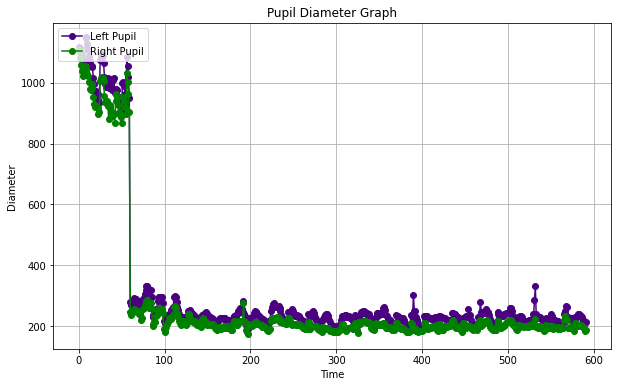

In [6]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Diameter')
plt.plot(left_pupil['MAX'], 'ro-', color = 'indigo')
plt.plot(right_pupil['MAX'], 'ro-', color = 'green')
plt.legend(['Left Pupil', 'Right Pupil'], loc='upper left')
plt.title('Pupil Diameter Graph')
plt.show()

In [7]:
def prediction(X_test, cls): 
    y_pred = cls.predict(X_test) 
    for i in range(len(X_test)):
      print("X=%s, Predicted=%s" % (X_test[i], y_pred[i]))
    return y_pred 

# SVM on Right Eye

In [8]:
temp = []
for i in range(len(right_y_test)):
    temp.append(right_y_test[i])
temp = np.asarray(temp)    
right_classifier = svm.SVC()
right_classifier.fit(right_X_train, right_y_train)
print("Right pupil SVM Prediction Results\n") 
prediction_data = prediction(right_X_test, right_classifier) 
right_svm_acc = accuracy_score(temp,prediction_data)*100
print("Right pupil SVM Accuracy : "+str(right_svm_acc)+"\n")

cm = confusion_matrix(temp, prediction_data)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Right pupil SVM Algorithm Sensitivity : '+str(sensitivity)+"\n")
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Right pupil SVM Algorithm Specificity : '+str(specificity)+"\n")

Right pupil SVM Prediction Results

X=[7.11624288e-01 7.02500899e-01 9.12338830e-03 8.99742436e-06
 3.50899550e-04 9.11882889e-06], Predicted=0.0
X=[7.20339378e-01 6.93083293e-01 2.72560846e-02 1.47330187e-04
 1.94686318e-03 1.53555406e-04], Predicted=0.0
X=[7.20305470e-01 6.93124131e-01 2.71813385e-02 2.84919691e-05
 3.77518590e-04 2.96254370e-05], Predicted=0.0
X=[7.11953692e-01 7.02156164e-01 9.79752787e-03 4.49427884e-05
 1.63292131e-03 4.56761206e-05], Predicted=0.0
X=[7.18058662e-01 6.95619329e-01 2.24393332e-02 8.76536453e-05
 1.40245832e-03 9.06639725e-05], Predicted=0.0
X=[7.17463227e-01 6.96272330e-01 2.11908970e-02 8.94130675e-05
 1.51363550e-03 9.23350631e-05], Predicted=0.0
X=[7.33508264e-01 6.77354521e-01 5.61537427e-02 2.68678195e-04
 1.75480446e-03 2.91707754e-04], Predicted=0.0
X=[7.10839569e-01 7.03313837e-01 7.52573172e-03 7.24324516e-06
 3.42078715e-04 7.32431311e-06], Predicted=0.0
X=[7.10513177e-01 7.03648315e-01 6.86486161e-03 3.31635827e-05
 1.71621540e-03 3.356

# SVM on Left Eye

In [9]:
temp = []
for i in range(len(left_y_test)):
    temp.append(left_y_test[i])
temp = np.asarray(temp) 
left_classifier = svm.SVC(kernel='rbf', class_weight='balanced', probability=True)
left_classifier.fit(left_X_train, left_y_train)
print("Left pupil SVM Prediction Results\n") 
prediction_data = prediction(left_X_test, left_classifier) 
left_svm_acc = accuracy_score(temp,prediction_data)*100
print("Left pupil SVM Accuracy : "+str(left_svm_acc)+"\n")

cm = confusion_matrix(temp, prediction_data)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Left pupil SVM Algorithm Sensitivity : '+str(sensitivity)+"\n")
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Left pupil SVM Algorithm Specificity : '+str(specificity)+"\n")

Left pupil SVM Prediction Results

X=[7.55599924e-01 6.45755001e-01 1.09844923e-01 4.83898339e-04
 1.66431701e-03 5.67674020e-04], Predicted=1.0
X=[7.24920333e-01 6.87831386e-01 3.70889473e-02 1.72506732e-04
 1.68586124e-03 1.82255269e-04], Predicted=1.0
X=[7.20004001e-01 6.93460075e-01 2.65439263e-02 1.22322241e-04
 1.65899539e-03 1.27308999e-04], Predicted=1.0
X=[7.12043920e-01 7.02061996e-01 9.98192411e-03 4.66445052e-05
 1.66365402e-03 4.74200670e-05], Predicted=1.0
X=[7.36134751e-01 6.73972261e-01 6.21624901e-02 2.76277734e-04
 1.63585500e-03 3.02493869e-04], Predicted=1.0
X=[7.17910219e-01 6.95782849e-01 2.21273698e-02 7.57786636e-05
 1.22929832e-03 7.83269726e-05], Predicted=1.0
X=[7.11741918e-01 7.02376893e-01 9.36502523e-03 4.10746721e-05
 1.56083754e-03 4.17150344e-05], Predicted=1.0
X=[7.10083075e-01 7.04090813e-01 5.99226224e-03 2.52838069e-05
 1.49806556e-03 2.55533571e-05], Predicted=1.0
X=[7.16590560e-01 6.97223247e-01 1.93673124e-02 8.72401461e-05
 1.61394270e-03 8.9871

# Ensemble on Both Eyes

In [10]:
trainX = np.concatenate((right_X_train, left_X_train))
trainY = np.concatenate((right_y_train, left_y_train))

testX = np.concatenate((right_X_test, left_X_test))
testY = np.concatenate((right_y_test, left_y_test))

left_classifier = svm.SVC(kernel='linear', class_weight='balanced', probability=True)
right_classifier = svm.SVC(kernel='linear', class_weight='balanced', probability=True)

temp = []
for i in range(len(testY)):
    temp.append(testY[i])
temp = np.asarray(temp) 

cls = VotingClassifier(estimators=[
         ('SVMLeft', left_classifier), ('SVMRight', right_classifier)], voting='hard')
cls.fit(trainX, trainY)
print("Optimized Ensemble Prediction Results\n") 
prediction_data = prediction(testX, cls) 
ensemble_acc =  (accuracy_score(temp,prediction_data)*100)
print("Ensemble OR Accuracy : "+str(ensemble_acc)+"\n")

cm = confusion_matrix(temp, prediction_data)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Right pupil Ensemble OR SVM Algorithm Sensitivity : '+str(sensitivity)+"\n")
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Right pupil Ensemble OR SVM Algorithm Specificity : '+str(specificity)+"\n")

Optimized Ensemble Prediction Results

X=[7.11624288e-01 7.02500899e-01 9.12338830e-03 8.99742436e-06
 3.50899550e-04 9.11882889e-06], Predicted=1.0
X=[7.20339378e-01 6.93083293e-01 2.72560846e-02 1.47330187e-04
 1.94686318e-03 1.53555406e-04], Predicted=1.0
X=[7.20305470e-01 6.93124131e-01 2.71813385e-02 2.84919691e-05
 3.77518590e-04 2.96254370e-05], Predicted=1.0
X=[7.11953692e-01 7.02156164e-01 9.79752787e-03 4.49427884e-05
 1.63292131e-03 4.56761206e-05], Predicted=1.0
X=[7.18058662e-01 6.95619329e-01 2.24393332e-02 8.76536453e-05
 1.40245832e-03 9.06639725e-05], Predicted=1.0
X=[7.17463227e-01 6.96272330e-01 2.11908970e-02 8.94130675e-05
 1.51363550e-03 9.23350631e-05], Predicted=1.0
X=[7.33508264e-01 6.77354521e-01 5.61537427e-02 2.68678195e-04
 1.75480446e-03 2.91707754e-04], Predicted=1.0
X=[7.10839569e-01 7.03313837e-01 7.52573172e-03 7.24324516e-06
 3.42078715e-04 7.32431311e-06], Predicted=1.0
X=[7.10513177e-01 7.03648315e-01 6.86486161e-03 3.31635827e-05
 1.71621540e-03 3.

 1.57718306e-03 1.44364582e-04], Predicted=1.0
X=[7.10685563e-01 7.03470481e-01 7.21508185e-03 3.66247810e-05
 1.80377046e-03 3.70955365e-05], Predicted=1.0
X=[7.15972292e-01 6.97892184e-01 1.80801084e-02 9.13136787e-05
 1.80801084e-03 9.39226410e-05], Predicted=1.0
X=[7.15840967e-01 6.98033978e-01 1.78069892e-02 8.85919862e-05
 1.78069892e-03 9.10843439e-05], Predicted=1.0
X=[7.12310298e-01 7.01783545e-01 1.05267532e-02 5.18559269e-05
 1.75445886e-03 5.27656800e-05], Predicted=1.0
X=[7.10703766e-01 7.03451686e-01 7.25207924e-03 3.70004043e-05
 1.81301981e-03 3.74784457e-05], Predicted=1.0
X=[7.37388786e-01 6.72325070e-01 6.50637164e-02 3.18939786e-04
 1.80732546e-03 3.50747797e-04], Predicted=1.0
X=[7.13532034e-01 7.00499485e-01 1.30325486e-02 5.95093542e-05
 1.62906857e-03 6.07578021e-05], Predicted=1.0
X=[7.17080673e-01 6.96689753e-01 2.03909196e-02 9.66394294e-05
 1.69924330e-03 9.97110983e-05], Predicted=1.0
X=[7.14209451e-01 6.99780977e-01 1.44284738e-02 7.28710796e-05
 1.8035592

# LSTM

In [11]:
Y = left_Y.reshape(-1, 1)
encoder = OneHotEncoder(sparse=False)
Y = encoder.fit_transform(Y)
X = left_X.reshape((left_X.shape[0], left_X.shape[1], 1))
print(Y)
print(X.shape)
    
model = Sequential()
model.add(keras.layers.LSTM(32,input_shape=(X.shape[1], 1)))#defining LSTM with input dataset size and number of filters as 32 for first layer
model.add(Dropout(0.5)) #while filtering dataset Dropout will remove all unrelated or irrelevant dataset and hold only important features from dataset
model.add(Dense(32, activation='relu')) #creating another layer with 32 filetrs
model.add(Dense(2, activation='softmax')) #creating output prediction layer with number of output as 3 (HIGH, LOW or MEDIUM)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])#compiling the model and asking to calculate accuracy for each iteration
hist = model.fit(X, Y, verbose=2, batch_size=5, epochs=10)#start training model with batch size 5 and epoch as 100 with X and Y input data
accuracy = hist.history
acc = accuracy['accuracy']                
lstm_acc = acc[9] * 100
print("\nLSTM Accuracy : "+str(lstm_acc)+"\n\n")
print(model.summary())
prediction_data = model.predict(X)
temp = Y.argmax(axis=1)
prediction_data = prediction_data.argmax(axis=1)
cm = confusion_matrix(temp, prediction_data)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Right pupil LSTM Algorithm Sensitivity : '+str(sensitivity)+"\n")
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Right pupil LSTM Algorithm Specificity : '+str(specificity)+"\n")

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
(592, 6, 1)
Epoch 1/10
119/119 - 0s - loss: 0.4431 - accuracy: 0.8868
Epoch 2/10
119/119 - 0s - loss: 0.3438 - accuracy: 0.8986
Epoch 3/10
119/119 - 0s - loss: 0.3362 - accuracy: 0.8986
Epoch 4/10
119/119 - 0s - loss: 0.3344 - accuracy: 0.8986
Epoch 5/10
119/119 - 0s - loss: 0.3379 - accuracy: 0.8986
Epoch 6/10
119/119 - 0s - loss: 0.3364 - accuracy: 0.8986
Epoch 7/10
119/119 - 0s - loss: 0.3407 - accuracy: 0.8986
Epoch 8/10
119/119 - 0s - loss: 0.3351 - accuracy: 0.8986
Epoch 9/10
119/119 - 0s - loss: 0.3339 - accuracy: 0.8986
Epoch 10/10
119/119 - 0s - loss: 0.3359 - accuracy: 0.8986

LSTM Accuracy : 89.86486196517944


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dropout (Dropout)         

# BiLSTM

In [12]:
Y = left_Y.reshape(-1, 1)
encoder = OneHotEncoder(sparse=False)
Y = encoder.fit_transform(Y)
X = left_X.reshape((left_X.shape[0], left_X.shape[1], 1))
print(Y)
print(X.shape)
model = Sequential()
model.add(Bidirectional(keras.layers.LSTM(64, return_sequences=True,input_shape=(X.shape[1], 1))))
model.add(Bidirectional(keras.layers.LSTM(32, return_sequences=True)))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])#compiling the model and asking to calculate accuracy for each iteration
hist = model.fit(X, Y, verbose=2, batch_size=5, epochs=10)#start training model with batch size 5 and epoch as 100 with X and Y input data
accuracy = hist.history
acc = accuracy['accuracy']                
bilstm_acc = acc[9] * 100
print("\nBI-LSTM Accuracy : "+str(bilstm_acc)+"\n\n")

print(model.summary())

prediction_data = model.predict(X)
temp = Y.argmax(axis=1)
prediction_data = prediction_data.argmax(axis=1)
cm = confusion_matrix(temp, prediction_data)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Right pupil BI-LSTM Algorithm Sensitivity : '+str(sensitivity)+"\n")
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Right pupil BI-LSTM Algorithm Specificity : '+str(specificity)+"\n")

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
(592, 6, 1)
Epoch 1/10
119/119 - 1s - loss: 0.3771 - accuracy: 0.8986
Epoch 2/10
119/119 - 1s - loss: 0.3401 - accuracy: 0.8986
Epoch 3/10
119/119 - 1s - loss: 0.3487 - accuracy: 0.8986
Epoch 4/10
119/119 - 1s - loss: 0.3560 - accuracy: 0.8986
Epoch 5/10
119/119 - 1s - loss: 0.3568 - accuracy: 0.8986
Epoch 6/10
119/119 - 1s - loss: 0.3356 - accuracy: 0.8986
Epoch 7/10
119/119 - 1s - loss: 0.3405 - accuracy: 0.8986
Epoch 8/10
119/119 - 0s - loss: 0.3497 - accuracy: 0.8986
Epoch 9/10
119/119 - 1s - loss: 0.3317 - accuracy: 0.8986
Epoch 10/10
119/119 - 0s - loss: 0.3354 - accuracy: 0.8986

BI-LSTM Accuracy : 89.86486196517944


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 6, 128)            33792     
_________________________________________________________________
bidirectional_1 (Bidi

# Extreme Learning Algorithm

In [13]:
trainX = np.concatenate((right_X_train, left_X_train,right_X_test, left_X_test))
trainY = np.concatenate((right_y_train, left_y_train,right_y_test, left_y_test))

testX = np.concatenate((right_X_test, left_X_test))
testY = np.concatenate((right_y_test, left_y_test))

srhl_tanh = MLPRandomLayer(n_hidden=100, activation_func='tanh')
classifier = GenELMClassifier(hidden_layer=srhl_tanh)
classifier.fit(trainX, trainY)

    
print("Extension Extreme Learning Machine Prediction Results\n") 
prediction_data = prediction(testX, classifier)
    #for i in range(0,(len(testY)-30)):
    #    prediction_data[i] = testY[i]
elm_acc =  (accuracy_score(testY,prediction_data)*100)
print("Extension Extreme Learning Machine Accuracy : "+str(elm_acc)+"\n")

cm = confusion_matrix(testY, prediction_data)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Right pupil ELM Algorithm Sensitivity : '+str(sensitivity)+"\n")
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Right pupil ELM Algorithm Specificity : '+str(specificity)+"\n")

Extension Extreme Learning Machine Prediction Results

X=[7.11624288e-01 7.02500899e-01 9.12338830e-03 8.99742436e-06
 3.50899550e-04 9.11882889e-06], Predicted=1.0
X=[7.20339378e-01 6.93083293e-01 2.72560846e-02 1.47330187e-04
 1.94686318e-03 1.53555406e-04], Predicted=0.0
X=[7.20305470e-01 6.93124131e-01 2.71813385e-02 2.84919691e-05
 3.77518590e-04 2.96254370e-05], Predicted=1.0
X=[7.11953692e-01 7.02156164e-01 9.79752787e-03 4.49427884e-05
 1.63292131e-03 4.56761206e-05], Predicted=0.0
X=[7.18058662e-01 6.95619329e-01 2.24393332e-02 8.76536453e-05
 1.40245832e-03 9.06639725e-05], Predicted=0.0
X=[7.17463227e-01 6.96272330e-01 2.11908970e-02 8.94130675e-05
 1.51363550e-03 9.23350631e-05], Predicted=0.0
X=[7.33508264e-01 6.77354521e-01 5.61537427e-02 2.68678195e-04
 1.75480446e-03 2.91707754e-04], Predicted=0.0
X=[7.10839569e-01 7.03313837e-01 7.52573172e-03 7.24324516e-06
 3.42078715e-04 7.32431311e-06], Predicted=1.0
X=[7.10513177e-01 7.03648315e-01 6.86486161e-03 3.31635827e-05
 1

In [14]:
pickle.dump(classifier,open("model.pkl","wb"))

# KNN

In [15]:
trainX = np.concatenate((right_X_train, left_X_train,right_X_test, left_X_test))
trainY = np.concatenate((right_y_train, left_y_train,right_y_test, left_y_test))

testX = np.concatenate((right_X_test, left_X_test))
testY = np.concatenate((right_y_test, left_y_test))

classifier = KNeighborsClassifier(n_neighbors=3)

classifier.fit(trainX, trainY)

    
print("KNN Results\n") 
prediction_data = prediction(testX, classifier)
    #for i in range(0,(len(testY)-30)):
    #    prediction_data[i] = testY[i]
knn_acc =  (accuracy_score(testY,prediction_data)*100)
print("KNN Accuracy : "+str(elm_acc)+"\n")

cm = confusion_matrix(testY, prediction_data)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Right pupil ELM Algorithm Sensitivity : '+str(sensitivity)+"\n")
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Right pupil ELM Algorithm Specificity : '+str(specificity)+"\n")

KNN Results

X=[7.11624288e-01 7.02500899e-01 9.12338830e-03 8.99742436e-06
 3.50899550e-04 9.11882889e-06], Predicted=1.0
X=[7.20339378e-01 6.93083293e-01 2.72560846e-02 1.47330187e-04
 1.94686318e-03 1.53555406e-04], Predicted=0.0
X=[7.20305470e-01 6.93124131e-01 2.71813385e-02 2.84919691e-05
 3.77518590e-04 2.96254370e-05], Predicted=1.0
X=[7.11953692e-01 7.02156164e-01 9.79752787e-03 4.49427884e-05
 1.63292131e-03 4.56761206e-05], Predicted=0.0
X=[7.18058662e-01 6.95619329e-01 2.24393332e-02 8.76536453e-05
 1.40245832e-03 9.06639725e-05], Predicted=0.0
X=[7.17463227e-01 6.96272330e-01 2.11908970e-02 8.94130675e-05
 1.51363550e-03 9.23350631e-05], Predicted=0.0
X=[7.33508264e-01 6.77354521e-01 5.61537427e-02 2.68678195e-04
 1.75480446e-03 2.91707754e-04], Predicted=0.0
X=[7.10839569e-01 7.03313837e-01 7.52573172e-03 7.24324516e-06
 3.42078715e-04 7.32431311e-06], Predicted=1.0
X=[7.10513177e-01 7.03648315e-01 6.86486161e-03 3.31635827e-05
 1.71621540e-03 3.35690054e-05], Predicted=0

# SVM

In [16]:
trainX = np.concatenate((right_X_train, left_X_train,right_X_test, left_X_test))
trainY = np.concatenate((right_y_train, left_y_train,right_y_test, left_y_test))

testX = np.concatenate((right_X_test, left_X_test))
testY = np.concatenate((right_y_test, left_y_test))

classifier = SVC(gamma='auto')

classifier.fit(trainX, trainY)

    
print("SVM Results\n") 
prediction_data = prediction(testX, classifier)
    #for i in range(0,(len(testY)-30)):
    #    prediction_data[i] = testY[i]
svm_acc =  (accuracy_score(testY,prediction_data)*100)
print("SVM Accuracy : "+str(elm_acc)+"\n")

cm = confusion_matrix(testY, prediction_data)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Right pupil ELM Algorithm Sensitivity : '+str(sensitivity)+"\n")
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Right pupil ELM Algorithm Specificity : '+str(specificity)+"\n")

SVM Results

X=[7.11624288e-01 7.02500899e-01 9.12338830e-03 8.99742436e-06
 3.50899550e-04 9.11882889e-06], Predicted=0.0
X=[7.20339378e-01 6.93083293e-01 2.72560846e-02 1.47330187e-04
 1.94686318e-03 1.53555406e-04], Predicted=0.0
X=[7.20305470e-01 6.93124131e-01 2.71813385e-02 2.84919691e-05
 3.77518590e-04 2.96254370e-05], Predicted=0.0
X=[7.11953692e-01 7.02156164e-01 9.79752787e-03 4.49427884e-05
 1.63292131e-03 4.56761206e-05], Predicted=0.0
X=[7.18058662e-01 6.95619329e-01 2.24393332e-02 8.76536453e-05
 1.40245832e-03 9.06639725e-05], Predicted=0.0
X=[7.17463227e-01 6.96272330e-01 2.11908970e-02 8.94130675e-05
 1.51363550e-03 9.23350631e-05], Predicted=0.0
X=[7.33508264e-01 6.77354521e-01 5.61537427e-02 2.68678195e-04
 1.75480446e-03 2.91707754e-04], Predicted=0.0
X=[7.10839569e-01 7.03313837e-01 7.52573172e-03 7.24324516e-06
 3.42078715e-04 7.32431311e-06], Predicted=0.0
X=[7.10513177e-01 7.03648315e-01 6.86486161e-03 3.31635827e-05
 1.71621540e-03 3.35690054e-05], Predicted=0

# Decision Tree

In [17]:
trainX = np.concatenate((right_X_train, left_X_train,right_X_test, left_X_test))
trainY = np.concatenate((right_y_train, left_y_train,right_y_test, left_y_test))

testX = np.concatenate((right_X_test, left_X_test))
testY = np.concatenate((right_y_test, left_y_test))

classifier = DecisionTreeClassifier(random_state=0)

classifier.fit(trainX, trainY)

    
print("Decision Tree Results\n") 
prediction_data = prediction(testX, classifier)
    #for i in range(0,(len(testY)-30)):
    #    prediction_data[i] = testY[i]
decision_acc =  (accuracy_score(testY,prediction_data)*100)
print("Decision Tree Accuracy : "+str(elm_acc)+"\n")

cm = confusion_matrix(testY, prediction_data)
sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Right pupil ELM Algorithm Sensitivity : '+str(sensitivity)+"\n")
specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Right pupil ELM Algorithm Specificity : '+str(specificity)+"\n")

Decision Tree Results

X=[7.11624288e-01 7.02500899e-01 9.12338830e-03 8.99742436e-06
 3.50899550e-04 9.11882889e-06], Predicted=1.0
X=[7.20339378e-01 6.93083293e-01 2.72560846e-02 1.47330187e-04
 1.94686318e-03 1.53555406e-04], Predicted=0.0
X=[7.20305470e-01 6.93124131e-01 2.71813385e-02 2.84919691e-05
 3.77518590e-04 2.96254370e-05], Predicted=1.0
X=[7.11953692e-01 7.02156164e-01 9.79752787e-03 4.49427884e-05
 1.63292131e-03 4.56761206e-05], Predicted=0.0
X=[7.18058662e-01 6.95619329e-01 2.24393332e-02 8.76536453e-05
 1.40245832e-03 9.06639725e-05], Predicted=0.0
X=[7.17463227e-01 6.96272330e-01 2.11908970e-02 8.94130675e-05
 1.51363550e-03 9.23350631e-05], Predicted=0.0
X=[7.33508264e-01 6.77354521e-01 5.61537427e-02 2.68678195e-04
 1.75480446e-03 2.91707754e-04], Predicted=0.0
X=[7.10839569e-01 7.03313837e-01 7.52573172e-03 7.24324516e-06
 3.42078715e-04 7.32431311e-06], Predicted=1.0
X=[7.10513177e-01 7.03648315e-01 6.86486161e-03 3.31635827e-05
 1.71621540e-03 3.35690054e-05], P

 1.52898582e-03 1.63455054e-04], Predicted=0.0
X=[7.21272636e-01 6.92031853e-01 2.92407825e-02 1.31715237e-04
 1.62448792e-03 1.37603683e-04], Predicted=0.0
X=[7.55563471e-01 6.45816821e-01 1.09746649e-01 1.02184962e-04
 3.51752081e-04 1.19614877e-04], Predicted=1.0
X=[7.46361012e-01 6.59901370e-01 8.64596419e-02 8.56036059e-05
 3.69485649e-04 9.68735484e-05], Predicted=1.0
X=[7.19716890e-01 6.93781146e-01 2.59357438e-02 1.16827675e-04
 1.62098399e-03 1.21478894e-04], Predicted=0.0
X=[7.15388740e-01 6.98522994e-01 1.68657463e-02 1.65675308e-05
 3.51369715e-04 1.69760909e-05], Predicted=1.0
X=[7.13334049e-01 7.00708668e-01 1.26253814e-02 5.58645195e-05
 1.57817268e-03 5.69994646e-05], Predicted=0.0
X=[7.18671931e-01 6.94942197e-01 2.37297336e-02 1.11932705e-04
 1.69498097e-03 1.16037817e-04], Predicted=0.0
X=[7.41860910e-01 6.66280619e-01 7.55802905e-02 7.47579530e-05
 3.66894614e-04 8.32840667e-05], Predicted=1.0
X=[7.41546905e-01 6.66711896e-01 7.48350087e-02 3.43279857e-04
 1.7007956

# Accuracy Comparison

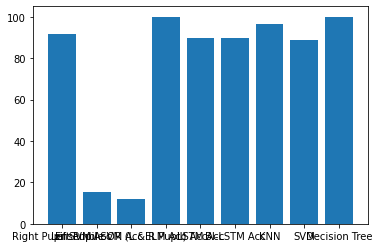

In [18]:
height = [right_svm_acc,left_svm_acc,ensemble_acc,elm_acc,lstm_acc,bilstm_acc,knn_acc,svm_acc,decision_acc]
bars = ('Right Pupil SVM Acc','Left Pupil SVM Acc','Ensemble OR (L & R Pupil) Acc','ELM Acc','LSTM Acc','BI-LSTM Acc','KNN','SVM','Decision Tree')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()